In [32]:
#clean up in v02 and run tests

import pandas as pd
import os
from tqdm import tqdm
import time
from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, Model, regularizers
from helper_functions.testing_functions import accuracy_distance, accuracy_moneyline, accuracy_ou
from helper_functions.simulate_game import simulate_game
from helper_functions.combine_matrices import combine_team_matrix
from tensorflow.keras.losses import Loss
import seaborn as sns
import pickle

In [2]:
avg_matrix = pd.read_excel('avg_transition_matrix_with_manual_edits.xlsx', sheet_name = 'Mean Pasted', index_col='Starting_State')

In [3]:
def pull_game_data(g):
        game_res = pd.read_excel('raw_game_pulls/{}'.format(g))
        game_strings = g.split(' vs ')
        team_A = game_strings[0].split('for ')[-1]
        team_B = game_strings[1].split('.xlsx')[0]

        matrix1 = pd.read_excel('team_specific_matrix/{}_A.xlsx'.format(team_A), index_col='Starting_State')
        matrix2 = pd.read_excel('team_specific_matrix/{}_B.xlsx'.format(team_B), index_col='Starting_State')

        A_score = game_res.iloc[-1]['Home']
        B_score = game_res.iloc[-1]['Away']
        score = (A_score,B_score)

        return matrix1, matrix2, score

In [4]:
#load game data
ma_list = []
mb_list = []
output_list = []

for game in tqdm(os.listdir('raw_game_pulls')):
    a,b,c = pull_game_data(game)
    ma_list.append(a)
    mb_list.append(b)
    output_list.append(c)

100%|██████████| 5498/5498 [05:31<00:00, 16.57it/s]


In [ ]:
#going to zip these into dicts to access by game ID

In [22]:
game_ids = []

In [23]:
for game in tqdm(os.listdir('raw_game_pulls')):
    game_ids.append(game.split('_')[0])

100%|██████████| 5498/5498 [00:00<00:00, 1836594.73it/s]


In [25]:
team_A_matrices_raw = dict(zip(game_ids, ma_list))
team_B_matrices_raw = dict(zip(game_ids, mb_list))
outputs_raw = dict(zip(game_ids, output_list))

In [5]:
#transform regular output data into argmax array form
arr_outputs = []
for x in output_list:
    value1, value2 = x

    # Create numpy arrays
    array1 = np.zeros(201)
    array2 = np.zeros(201)

    # Set the corresponding indices to 1
    array1[value1 - 1] = 1
    array2[value2 - 1] = 1 
    arr_outputs.append((array1, array2))

In [26]:
outputs_array = dict(zip(game_ids, arr_outputs))

In [6]:
#normalize inputs ###############################################################################
all_inputs=ma_list+mb_list

arr = np.array([df.values for df in all_inputs])

# Calculate mean and standard deviation across the first axis (which represents different DataFrames)
avg = np.mean(arr, axis=0)
std_dev = np.std(arr, axis=0)

# Create DataFrames from the calculated arrays
avg_df = pd.DataFrame(avg, index=all_inputs[0].index, columns=all_inputs[0].columns)
std_dev_df = pd.DataFrame(std_dev, index=all_inputs[0].index, columns=all_inputs[0].columns)

norm_inputs_a = []
norm_inputs_b = []

#Normalize each value in each matrix
for matrix in ma_list:
    normalized_matrix = (matrix - avg_df) / std_dev_df
    normalized_matrix=normalized_matrix.fillna(0.)
    norm_inputs_a.append(normalized_matrix)

for matrix in mb_list:
    normalized_matrix = (matrix - avg_df) / std_dev_df
    normalized_matrix=normalized_matrix.fillna(0.)
    norm_inputs_b.append(normalized_matrix)

In [27]:
team_A_matrices_normal = dict(zip(game_ids, norm_inputs_a))
team_B_matrices_normal = dict(zip(game_ids, norm_inputs_b))

In [30]:
saved_sim_ids = [x.split('.')[0] for x in os.listdir('saved_sims_small')]

In [35]:
simulated_scores = []
for x in  os.listdir('saved_sims_small'):
    with open('saved_sims_small/{}'.format(x), 'rb') as file:
        data=pickle.load(file)
        simulated_scores.append(data)

In [37]:
simulated_scores_dict = dict(zip(saved_sim_ids, simulated_scores))

In [39]:
train_index, test_index = train_test_split(list(simulated_scores_dict.keys()), test_size=0.2)

In [75]:
#split on index for now, later will match with simulations

#matrix_A_train is list of normalized input matrices used for training NN
matrix_A_train = [team_A_matrices_normal[x] for x in train_index]
matrix_B_train = [team_B_matrices_normal[x] for x in train_index]


#y_train is training list of argmax formatted outputs
y_train = [outputs_array[x] for x in train_index]

#matrix_A_test is list of normalized input matrices used for testing NN
matrix_A_test = [team_A_matrices_normal[x] for x in test_index]
matrix_B_test = [team_B_matrices_normal[x] for x in test_index]

#y_test is testing list of argmax formatted outputs
y_test=[outputs_array[x] for x in test_index]

final_scores_test = [outputs_raw[x] for x in test_index]

In [47]:
#do same as above for regular simulation testing - not normalized and no training data needed

simulation_output_test = [simulated_scores_dict[x] for x in test_index]

In [50]:
def test_nn_output(model, game_index, num_sims):
    #Pull and Convert test matrices to numpy arrays
    test_matrix_a_array = matrix_A_test[game_index].values.reshape(-1, 18, 18)
    test_matrix_b_array = matrix_B_test[game_index].values.reshape(-1, 18, 18)

    predictions = model.predict([test_matrix_a_array, test_matrix_b_array], verbose=0)

    home_scores = np.random.choice(np.arange(1,202), num_sims, p=predictions[0][0])
    away_scores = np.random.choice(np.arange(1,202), num_sims, p=predictions[1][0])

    current_df = pd.DataFrame(zip(home_scores, away_scores), columns = ['Home','Away'])
    current_df['Game']=game_index
    return current_df

In [51]:
#not working right now
# Define custom loss function
class Distance(Loss):
    def call(self, y_true, y_pred):
        # Reshape the input tensors if necessary
        y_true_reshaped = tf.reshape(y_true, (-1, 201))  # Assuming 101 is the number of classes
        y_pred_reshaped = tf.reshape(y_pred, (-1, 201))

        # Compute the argmax operation with the correct axis
        a_pred = tf.argmax(y_pred_reshaped[0], axis=1)
        b_pred = tf.argmax(y_pred_reshaped[1], axis=1)

        # Compute the argmax operation for the true labels as well
        a_true = tf.argmax(y_true_reshaped[0], axis=1)
        b_true = tf.argmax(y_true_reshaped[1], axis=1)

        # Compute the loss based on the difference between predicted and true values

        global loss
        global egg
        # egg = tf.reduce_mean(tf.math.square(y_pred - y_true), axis=-1)
        loss = tf.sqrt(tf.cast(tf.square(a_true - a_pred), dtype=tf.float32) + tf.cast(tf.square(b_true - b_pred), dtype=tf.float32))
        # return egg

        return loss

In [52]:
# #attempting to train with customized loss function
# def custom_loss(y_true, y_pred,):
#     # Reshape the input tensors if necessary
#     y_true_reshaped = tf.reshape(y_true, (-1, 201))  # Assuming 101 is the number of classes
#     y_pred_reshaped = tf.reshape(y_pred, (-1, 201))

#     # Compute the argmax operation with the correct axis
#     a_pred = tf.argmax(y_pred_reshaped[0], axis=1)
#     b_pred = tf.argmax(y_pred_reshaped[1], axis=1)

#     # Compute the argmax operation for the true labels as well
#     a_true = tf.argmax(y_true_reshaped[0], axis=1)
#     b_true = tf.argmax(y_true_reshaped[1], axis=1)

#     # Compute the loss based on the difference between predicted and true values
#     loss = tf.sqrt(tf.cast(tf.square(a_true - a_pred), dtype=tf.float32) + tf.cast(tf.square(b_true - b_pred), dtype=tf.float32))
#     return loss

In [ ]:
#variables list

#ALL GAMES:
#team_A_matrices_raw - dict of key: game_id, val: home team matrix
#team_B_matrices_raw - dict of key: game_id, val: away team matrix
#outputs_raw - dict of key: game_id, val: final score tuple
#outputs_array - dict of key: game_id, val: array version of output (one-hot format)
#team_A_matrices_normal - dict of key: game_id, val: normalized home team matrix
#team_B_matrices_normal - dict of key: game_id, val: normalized away team matrix

#saved_sim_ids - list of game IDS in simulated data
#simulated_scores_dict - dict of key: game_id, val: list of 1000 score tuples

#train_index, test_index - lists of game id's for training and testing

#TRAINING GAMES:
#matrix_A_train - list of normalized home team matrices for training
#matrix_B_train - list of normalized away team matrices for training
#y_train - list of one-hot outputs for training

#TESTING GAMES:
#matrix_A_test - list of normalized home team matrices for testing
#matrix_B_test - list of normalized away team matrices for testing
#y_test - list of one-hot outputs for testing

#simulation_output_test - list of 1000 score tuples for testing
#final_scores_test - 

In [74]:
# Define the neural network architecture
def build_model():
    input1 = layers.Input(shape=(18, 18))
    input2 = layers.Input(shape=(18, 18))

    flatten1 = layers.Flatten()(input1)
    flatten2 = layers.Flatten()(input2)

    concat = layers.Concatenate()([flatten1, flatten2])
    dense1 = layers.Dense(200, activation='relu')(concat)
    dense2 = layers.Dense(100, activation='relu')(dense1)

    output1 = layers.Dense(201, activation='softmax', name='output1')(dense2)  # Adjust output dimension to match the range (150 - 50 + 1)
    output2 = layers.Dense(201, activation='softmax', name='output2')(dense2)  # Adjust output dimension to match the range (150 - 50 + 1)

    model = Model(inputs=[input1, input2], outputs=[output1, output2])
    return model

# Define your training function
def train_model(matrixA_list, matrixB_list, output_tuple_list, epochs=10, batch_size=32):
    # Convert DataFrame to numpy arrays
    matrixA_array = np.array(matrixA_list)
    matrixB_array = np.array(matrixB_list)
    output_array = np.array(output_tuple_list)
    
    # Build the model
    model = build_model()

    # Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit([matrixA_array, matrixB_array], [output_array[:, 0], output_array[:, 1]], epochs=epochs, batch_size=batch_size)
    return model

In [54]:
m1 = train_model(matrix_A_train, matrix_B_train, y_train, 10, 64)

Epoch 1/10
69/69 [==============================] - 1s 3ms/step - loss: 9.0141 - output1_loss: 4.5553 - output2_loss: 4.4588 - output1_accuracy: 0.0289 - output2_accuracy: 0.0243  
Epoch 2/10
69/69 [==============================] - 0s 3ms/step - loss: 7.6878 - output1_loss: 3.8858 - output2_loss: 3.8020 - output1_accuracy: 0.0639 - output2_accuracy: 0.0673
Epoch 3/10
69/69 [==============================] - 0s 3ms/step - loss: 7.2923 - output1_loss: 3.6820 - output2_loss: 3.6104 - output1_accuracy: 0.0973 - output2_accuracy: 0.1051
Epoch 4/10
69/69 [==============================] - 0s 3ms/step - loss: 6.9376 - output1_loss: 3.4947 - output2_loss: 3.4429 - output1_accuracy: 0.1324 - output2_accuracy: 0.1367
Epoch 5/10
69/69 [==============================] - 0s 3ms/step - loss: 6.5993 - output1_loss: 3.3171 - output2_loss: 3.2821 - output1_accuracy: 0.1699 - output2_accuracy: 0.1733
Epoch 6/10
69/69 [==============================] - 0s 3ms/step - loss: 6.2564 - output1_loss: 3.1429 -

In [55]:
predicted_scores = []
all_predictions_list = []
for i in tqdm(range(len(matrix_A_test))):
    # Convert test matrices to numpy arrays
    test_matrix_a_array = matrix_A_test[i].values.reshape(-1, 18, 18)
    test_matrix_b_array = matrix_B_test[i].values.reshape(-1, 18, 18)

    # Make predictions using the model
    predictions = m1.predict([test_matrix_a_array, test_matrix_b_array], verbose=0)
    all_predictions_list.append(predictions)

    predicted_score = (np.argmax(predictions[0]), np.argmax(predictions[1]))

    predicted_scores.append(predicted_score)

100%|██████████| 1100/1100 [00:44<00:00, 24.45it/s]


In [13]:
#design test for outputs - we have ~1200 test games
#one approach - run simulation 10-100 times for each, find overall accuracy, test against argmax values
#one approach - run simulation 10 times for each, run random weighted choice 10 times for each, compare

In [89]:
def calc_dist(x1,x2,y1,y2):
    return np.sqrt((x1-y1)**2 + (x2-y2)**2)

def calc_ou(x1,x2,y1,y2):
    return (y1+y2) - (x1+x2)

def calc_winner(x1,x2,y1,y2):
    return (x1>x2)==(y1>y2)

def calc_score(data, var='Distance'):
    if var == 'Distance':
        func = np.vectorize(calc_dist)
    elif var == 'OU':
        func=np.vectorize(calc_ou)
    elif var == 'Winner':
        func=np.vectorize(calc_winner)

    result = func(data['Real Home Score'],
                    data['Real Away Score'],
                    data['Projected Home Score'],
                    data['Projected Away Score'])
    return result

In [90]:
data_list = []
for g in tqdm(range(len(final_scores_test))):
    real_score = final_scores_test[g]
    current_1000 = simulation_output_test[g]
    current_df = pd.DataFrame(current_1000, columns=['Projected Home Score','Projected Away Score'])
    current_df['Game'] = g
    current_df['Real Home Score'] = real_score[0]
    current_df['Real Away Score'] = real_score[1]
    data_list.append(current_df)
testing_dataframe = pd.concat(data_list).reset_index(drop=True)

  0%|          | 0/1100 [00:00<?, ?it/s]

100%|██████████| 1100/1100 [00:01<00:00, 1017.63it/s]


In [93]:
testing_dataframe['Distance'] = calc_score(testing_dataframe)

In [94]:
testing_dataframe['OU'] = calc_score(testing_dataframe, 'OU')

In [95]:
testing_dataframe['Winner'] = calc_score(testing_dataframe, 'Winner')

In [96]:
testing_dataframe

,Projected Home Score,Projected Away Score,Game,Real Home Score,Real Away Score,Distance,OU,Winner
0,94,79,0,83,75,11.704700,15,True
1,91,74,0,83,75,8.062258,7,True
2,89,80,0,83,75,7.810250,11,True
3,78,70,0,83,75,7.071068,-10,True
4,73,66,0,83,75,13.453624,-19,True
...,...,...,...,...,...,...,...,...
1099995,94,92,1099,78,80,20.000000,28,False
1099996,75,80,1099,78,80,3.000000,-3,True
1099997,93,88,1099,78,80,17.000000,23,False
1099998,85,69,1099,78,80,13.038405,-4,False


In [97]:
testing_df_grouped = testing_dataframe.groupby('Game')[['Distance','OU','Winner']].mean().reset_index()

In [98]:
testing_df_grouped

,Game,Distance,OU,Winner
0,0,14.041345,-0.360,0.458
1,1,28.352138,36.388,0.470
2,2,18.996364,-1.791,0.630
3,3,21.739224,24.644,0.436
4,4,17.832521,18.861,0.584
...,...,...,...,...
1095,1095,21.968424,25.455,0.574
1096,1096,14.624220,12.438,0.640
1097,1097,30.693374,40.145,0.672
1098,1098,14.179585,-3.287,0.507


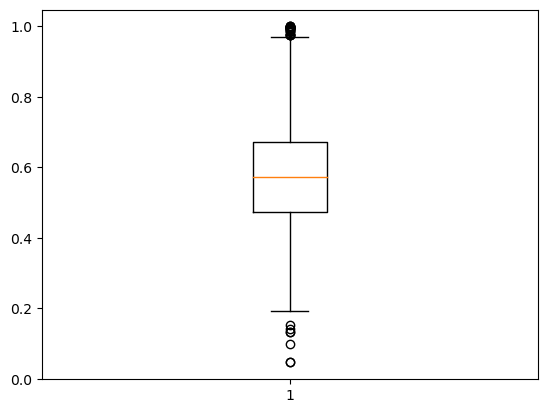

In [102]:
plt.boxplot(testing_df_grouped['Winner']);

In [81]:
real_results = real_results.rename(columns={'Home':'Real Home Score',
                                                    'Away':'Real Away Score'})

In [82]:
sim_results = sim_results.rename(columns={'Home':'Projected Home Score',
                                                    'Away':'Projected Away Score'})

In [83]:
#now random choice NN results
nn_results = pd.DataFrame()
for g in games_to_test:
    #locate teams to find matrices
    current_df = test_nn_output(m1, g, 100)
    nn_results=pd.concat([nn_results,current_df])

In [162]:
#now argmax nn results
nn_results_best = pd.DataFrame()
for g in games_to_test:
    test_matrix_a_array = matrix_A_test[g].values.reshape(-1, 18, 18)
    test_matrix_b_array = matrix_B_test[g].values.reshape(-1, 18, 18)

    predictions = m1.predict([test_matrix_a_array, test_matrix_b_array], verbose=0)

    predicted_score = (np.argmax(predictions[0]), np.argmax(predictions[1]))
    current_df = pd.DataFrame([predicted_score], columns = ['Projected Home Score','Projected Away Score'])
    current_df['Game']=g
    nn_results_best=pd.concat([nn_results_best,current_df])

In [85]:
nn_results=nn_results.rename(columns={'Home':'Projected Home Score',
                                                    'Away':'Projected Away Score'})

In [165]:
merged_results_dict = dict()

In [167]:
models = ['Sim', 'NN1', 'NN Best']


In [195]:
merged_results_dict['Sim'] = real_results.merge(sim_results, on='Game', how='right')
merged_results_dict['NN1'] = real_results.merge(nn_results, on='Game', how='right')
merged_results_dict['NN Best'] = real_results.merge(nn_results_best, on='Game', how='right')

merged_results_list = list(merged_results_dict.values())

In [196]:
for m in merged_results_list:
    m['Distance Score'] = calc_score(m, 'Distance')
    m['OU Score'] = calc_score(m, 'OU')
    m['Winner Score'] = calc_score(m, 'Winner')

In [197]:
grouped_data_dict = dict()

In [198]:
for m in range(len(models)):
    grouped_data_dict[models[m]] = merged_results_list[m][['Game','Distance Score','OU Score', 'Winner Score']]\
    .groupby('Game').mean().reset_index()

In [199]:
p1_data = pd.DataFrame()
p2_data = pd.DataFrame()
p3_data = pd.DataFrame()

for m in models:
    data=grouped_data_dict[m]
    p1_data[m] = data['Distance Score']
    p2_data[m] = data['OU Score']
    p3_data[m] = data['Winner Score']

p1_data=p1_data.melt()
p2_data=p2_data.melt()
p3_data=p3_data.melt()

<AxesSubplot:xlabel='variable', ylabel='value'>

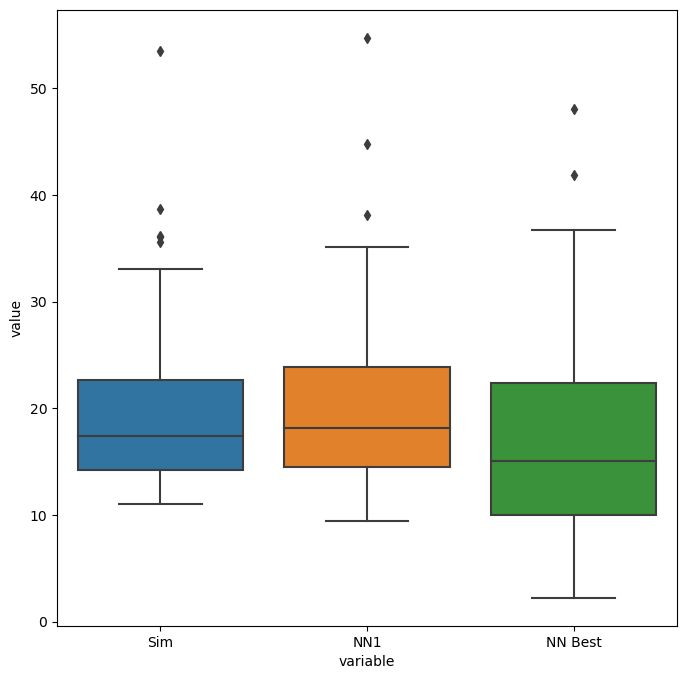

In [200]:
fig, ax=plt.subplots(figsize=(8,8))
sns.boxplot(x='variable', y='value', data=p1_data)

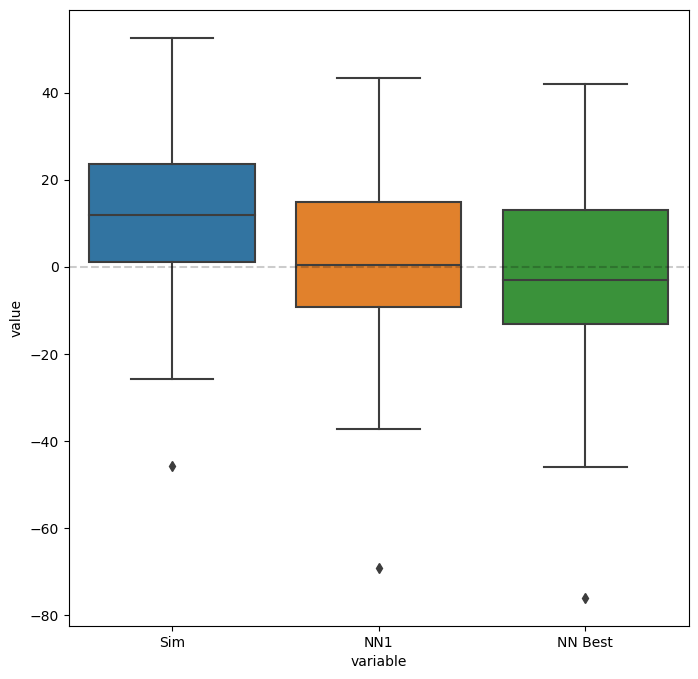

In [201]:
fig, ax=plt.subplots(figsize=(8,8))
sns.boxplot(x='variable', y='value', data=p2_data, )
plt.plot(np.linspace(-0.5,2.5,100), np.repeat(0,100), color = 'black', linestyle='--', alpha=0.2)

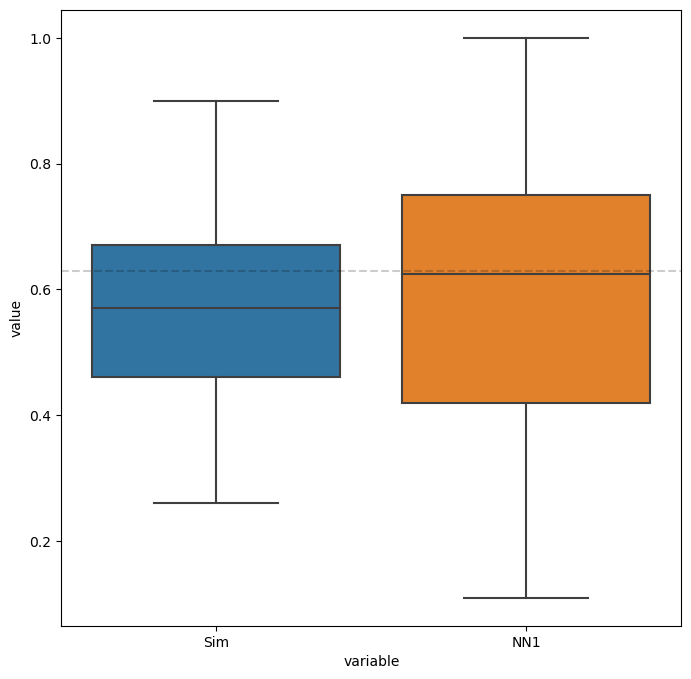

In [206]:
fig, ax=plt.subplots(figsize=(8,8))
sns.boxplot(x='variable', y='value', data=p3_data[p3_data['variable']!='NN Best'])
plt.plot(np.linspace(-0.5,1.5,100),
          np.repeat(p3_data[p3_data['variable']=='NN Best']['value'].mean(),100),
          color = 'black', linestyle='--', alpha=0.2)

In [203]:
p3_data

,variable,value
0,Sim,0.68
1,Sim,0.43
2,Sim,0.72
3,Sim,0.80
4,Sim,0.55
...,...,...
295,NN Best,1.00
296,NN Best,1.00
297,NN Best,1.00
298,NN Best,0.00


In [84]:
merged_results['Simulation Winner Score'].mean()

0.5319320937752627

In [85]:
merged_results['NN Winner Score'].mean()

0.5901374292643492

In [43]:
len(predictions)

2

In [32]:
game_res

(65, 90)

In [47]:
res=np.random.choice(np.arange(1,202), 1, p=predictions[0][0])

In [48]:
res

array([66])

In [17]:
combined_matrix = combine_team_matrix(matrix1, matrix2)

In [ ]:
##### OLD CODE BELOW FOR SECOND NN ARCHITECTURE - MAY REVISIT LATER

In [92]:
res.max()

108

In [51]:
len(predictions[0][0])

201

In [43]:
real_scores = output_list[4000:]

In [44]:
accuracy_distance(predicted_scores,real_scores)

15.26440597207573

In [60]:
def build_regularized_model():
    input1 = layers.Input(shape=(18, 18))
    input2 = layers.Input(shape=(18, 18))

    flatten1 = layers.Flatten()(input1)
    flatten2 = layers.Flatten()(input2)

    concat = layers.Concatenate()([flatten1, flatten2])
    
    # Wide sparse layers with L1 regularization
    dense1 = layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l1(0.01))(concat)
    dropout1 = layers.Dropout(0.5)(dense1)
    
    dense2 = layers.Dense(256, activation='sigmoid', kernel_regularizer=regularizers.l1(0.01))(dropout1)
    dropout2 = layers.Dropout(0.5)(dense2)

    # Wide sparse layers with L1 regularization
    dense3 = layers.Dense(2048, activation='relu', kernel_regularizer=regularizers.l1(0.01))(dropout2)
    dropout3 = layers.Dropout(0.5)(dense2)
    
    dense4 = layers.Dense(64, activation='sigmoid', kernel_regularizer=regularizers.l1(0.01))(dropout3)
    dropout4 = layers.Dropout(0.5)(dense3)

    d5=layers.Dense(102377, activation='sigmoid')(dense4)
    d6=layers.Dense(219, activation='sigmoid')(d5)
    d7=layers.Dense(23456, activation='relu')(d6)
    d8=layers.Dense(129, activation='softmax')(d7)
    d9=layers.Dense(32, activation='sigmoid')(d8)

    output1 = layers.Dense(201, activation='softmax', name='output1')(d9)  # Adjust output dimension to match the range (150 - 50 + 1)
    output2 = layers.Dense(201, activation='softmax', name='output2')(d9)  # Adjust output dimension to match the range (150 - 50 + 1)

    model = Model(inputs=[input1, input2], outputs=[output1, output2])
    return model

In [140]:
def train_model_2(matrixA_list, matrixB_list, output_tuple_list, epochs=10, batch_size=32):
    # Convert DataFrame to numpy arrays
    matrixA_array = np.array(matrixA_list)
    matrixB_array = np.array(matrixB_list)
    output_array = np.array(output_tuple_list)
    
    # Build the model
    model = build_regularized_model()

    # Compile the model
    model.compile(optimizer='adam', loss=custom_loss, metrics=['accuracy'])

    # Train the model
    model.fit([matrixA_array, matrixB_array], [output_array[:, 0], output_array[:, 1]], epochs=epochs, batch_size=batch_size)
    return model

In [ ]:
m2 = train_model_2(matrix_A_train, matrix_B_train, y_train, 10, 64)

In [126]:
a

<tf.Tensor 'IteratorGetNext:3' shape=(None, 201) dtype=float32>

In [111]:
predicted_scores_2 = []
for i in tqdm.tqdm(range(len(matrix_A_test))[:10]):
    # Convert test matrices to numpy arrays
    test_matrix_a_array = matrix_A_test[i].values.reshape(-1, 18, 18)
    test_matrix_b_array = matrix_B_test[i].values.reshape(-1, 18, 18)

    # Make predictions using the model
    predictions = m2.predict([test_matrix_a_array, test_matrix_b_array], verbose=0)

    predicted_score = (np.argmax(predictions[0]), np.argmax(predictions[1]))

    predicted_scores_2.append(predicted_score)

100%|██████████| 10/10 [00:00<00:00, 18.60it/s]


In [112]:
predicted_scores_2

[(76, 69),
 (76, 69),
 (76, 69),
 (76, 69),
 (76, 69),
 (76, 69),
 (76, 69),
 (76, 69),
 (76, 69),
 (76, 69)]